In [ ]:
!pip install -q -U 'tensorflow-text==2.8.*'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 2.0 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [ ]:
!pip install -q tf-models-official

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import re
import time
import unicodedata
import datetime
import pathlib
import json

from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import layers

import tensorflow_hub as hub
import tensorflow_models as tfm

import tensorflow_text as text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

In [ ]:
tf.get_logger().setLevel('ERROR')
tf.config.run_functions_eagerly(True)

## Parametri BERT

In [ ]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  
tfhub_handle_encoder =  'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'

print('BERT model selected                : ', tfhub_handle_encoder)

### Variabili Globali

In [ ]:
# root e filename
root_folder = 'drive/MyDrive/BERT/'

# Folder data
data_folder_name = 'data'

# File utilizzati per l'addestramento
data_filename = ['generative_fiore_it.csv',
                 'generative_fiore_it_en.csv',
                 'generative_fiore_it_de.csv',
                 'generative_fiore_it_fr.csv',
                 'generative_fiore_it_es.csv']

# File di train
train_filename = 'dataset_dantesco.csv'

In [ ]:
# PATH
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
# data_filenamepath = os.path.abspath(os.path.join(DATA_PATH, data_filename))
train_data_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))

# PATH LOG Tensorboard
PATH_LOG = 'logs/fit/transformer_bert_dante'
PATH_LOG = os.path.abspath(os.path.join(root_folder, PATH_LOG))
log_dir =  os.path.abspath(os.path.join(PATH_LOG, datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))) 
log_history = os.path.abspath(os.path.join(PATH_LOG, 'histrory.json'))

# PATH WEIGHTS Tensorboard
PATH_WEIGHTS = 'weights/generative_fiore_it'
PATH_WEIGHTS = os.path.abspath(os.path.join(root_folder, PATH_WEIGHTS))
checkpoint_path = os.path.abspath(os.path.join(PATH_WEIGHTS, 'cp.ckpt'))

# VOCABOLARIO
vocab_folder = 'vocab'
ita_vocab_finalname = 'ita_vocab_dante.txt'
dan_vocab_finalname = 'dan_vocab_dante.txt'

VOCAB_PATH = os.path.abspath(os.path.join(root_folder, vocab_folder))
ita_vocab_filenamepath = os.path.abspath(os.path.join(VOCAB_PATH, ita_vocab_finalname))
dan_vocab_filenamepath = os.path.abspath(os.path.join(VOCAB_PATH, dan_vocab_finalname))

In [ ]:
# parametri per il modello
ORIGINAL_COLUMN = 'Original'
TRANSLATE_COLUMN = 'Translate'
TRANSLATE_COLUMN_GPT = 'Translate_GPT_1'

# parametri per il modello
NUM_SAMPLES = 68248 
TRAIN = 24000
VALIDATION = 8000
N_VALIDATION = 1
TEST = 100

MAX_VOCAB_SIZE = 20000 
EMBEDDING_DIM = 64
HIDDEN_DIM = 1024 # numero di celle nei layer ricorrenti nascosti

BATCH_SIZE = 32
BUFFER_SIZE = 2000
MAX_SEQ_LENGTH = 64

NUM_LAYERS = 3 # Numero di layer di Decoder del Transformer
NUM_HEADS = 8 # Numero di meccanismi di multi-head attention
FF_DIM = 16 # Numero di celle dei Layer Feed Forward
DROPUOT = 0.5

# Ottimizzatore Adam
LEARNING_RATE_ADAM = 1e-4
BETA_1 = 0.66
BETA_2 = 0.999
EPOCHS_ADAM = 25

# IMPOSTO IL DEBUG A TRUE 
debug = True
training = True

## DATASET

### Caricamento Dati

In [ ]:
def union_df_train():
  df = pd.DataFrame(columns=[ORIGINAL_COLUMN, TRANSLATE_COLUMN])
  
  for filename in data_filename:
    filename_path = os.path.abspath(os.path.join(DATA_PATH, filename))

    df_train = pd.read_csv(
      filename_path,
      usecols=[ORIGINAL_COLUMN, TRANSLATE_COLUMN, TRANSLATE_COLUMN_GPT],
      dtype={ORIGINAL_COLUMN: str, TRANSLATE_COLUMN: str, TRANSLATE_COLUMN_GPT: str}
    )

    df_train = pd.concat([df_train[[ORIGINAL_COLUMN, TRANSLATE_COLUMN]], 
                          df_train[[ORIGINAL_COLUMN, TRANSLATE_COLUMN_GPT]]. \
                          rename(columns={TRANSLATE_COLUMN_GPT: TRANSLATE_COLUMN})])
    
    df = df.append(df_train)
  
  return df.reset_index(drop=True)

In [ ]:
exist_data_file = Path(train_data_filenamepath)

if not exist_data_file.exists():
  # Caricamento dataset
  df = union_df_train()

  # Mischio il dataset in modo che sia più uniforme tra train e test
  df = df.iloc[np.random.permutation(df.index)].reset_index(drop=True)
  df = df.iloc[:TRAIN+VALIDATION+TEST]

  print(df.iloc[-4:], '\n')

  df.to_csv(train_data_filenamepath, index=False, columns=[ORIGINAL_COLUMN, TRANSLATE_COLUMN])

                                       Original  \
32096          E’ non sapea ove trovar socorso,   
32097  Contra lo Schifo, ch’è molto oltragioso,   
32098    Per c’altra volta n’è stata   beffata;   
32099       Ma chui piaciesse   tal amonizione,   

                                               Translate  
32096             et ne savait pas où trouver du secours  
32097  Wir kämpfen gegen die Abscheulichkeit, die äuß...  
32098                  porque una vez la habían engañado  
32099                        but who liked such warnings   



In [ ]:
exist_data_file

PosixPath('/content/drive/MyDrive/BERT/data/train_dataset_fiore.csv')

In [ ]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence_dante(w):
  '''
  Preprocessing dei testi di input, impostando tutti i caratteri
  minuscoli, aggiungendo uno spazio prima di ogni punto e sostituendo
  qualsiasi carattere con uno spazio se non è compreso nel seguente elenco:
  (a-z, A-Z, ".", "?", "!", ",", "'", "’")
  '''
  #w = unicode_to_ascii(w.lower().strip())

  # inserimento di uno spazio tra ogni parola e il successivo punto,
  # punto esclamativo, punto interrogativo e virgola
  # esempio: "ciao, come và?" => "ciao , come và ?"
  w = re.sub(r"([?.!,])", r" \1 ", w) # inserimento di uno spazio

  # sostituzione dei caratteri apostrofo
  w = re.sub(r"([’]+)", "'", w)

  w = w.replace("á", "à")
  w = w.replace("é", "è")
  w = w.replace("í", "ì")
  w = w.replace("ó", "ò")
  w = w.replace("ú", "ù")

  # sostituzione dei caratteri non desiderati con uno spazio
  w = re.sub(r"([^a-zA-Z?.!,'àèìòù]+)", " ", w)

  # inserimento di uno spazio dopo apostrofo
  w = re.sub(r"(['])", r"\1 ", w) 

  w = w.replace(" ' ", " '")

  w = re.sub(r'[" "]+', " ", w) # rimozione di più spazi consecutivi
  return w

def preprocess_sentence(w):
  '''
  Preprocessing dei testi di input, impostando tutti i caratteri
  minuscoli, aggiungendo uno spazio prima di ogni punto e sostituendo
  qualsiasi carattere con uno spazio se non è compreso nel seguente elenco:
  (a-z, A-Z, ".", "?", "!", ",", "'", "’")
  '''
  w = unicode_to_ascii(w.lower().strip())

  # inserimento di uno spazio tra ogni parola e il successivo punto,
  # punto esclamativo, punto interrogativo e virgola
  # esempio: "ciao, come và?" => "ciao , come và ?"
  w = re.sub(r"([?.!,])", r" \1 ", w) # inserimento di uno spazio

  # sostituzione dei caratteri non desiderati con uno spazio
  w = re.sub(r"([^a-zA-Z?.!,]+)", " ", w)

  # inserimento di uno spazio dopo apostrofo
  w = re.sub(r"(['])", r"\1 ", w) 

  w = re.sub(r'[" "]+', " ", w) # rimozione di più spazi consecutivi
  return w

In [ ]:
df = pd.read_csv(
  train_data_filenamepath,
)

# Mischio il dataset in modo che sia più uniforme tra train e test
df = df.iloc[np.random.permutation(df.index)].reset_index(drop=True)

# Preprocessing dei dati di Input
input_data = df[TRANSLATE_COLUMN].apply(lambda x : preprocess_sentence(x)).tolist()

# Preprocessing dei dati Target con aggiunta del token di fine frase
target_data = df[ORIGINAL_COLUMN].apply(lambda x : preprocess_sentence_dante(x)).tolist()

train_input_data = input_data[:TRAIN]
train_target_data = target_data[:TRAIN]

validation_input_data = input_data[TRAIN:TRAIN+VALIDATION]
validation_target_data = target_data[TRAIN:TRAIN+VALIDATION]

test_input_data = input_data[TRAIN+VALIDATION:TRAIN+VALIDATION+TEST]
test_target_data = target_data[TRAIN+VALIDATION:TRAIN+VALIDATION+TEST]

print(f'Dati totali presenti nel Dataset               : {len(df)}')
print(f'Dati totali presenti nel Dataset di Train      : {len(train_input_data)}')
print(f'Dati totali presenti nel Dataset di Validation : {len(validation_input_data)}')
print(f'Dati totali presenti nel Dataset di Test       : {len(test_input_data)}\n')

print('-----------TRAIN SET--------------')
print(train_input_data[-4:])
print(train_target_data[-4:])
print('-----------VALIDATION SET---------------')
print(validation_input_data[-4:])
print(validation_target_data[-4:])
print('-----------TEST SET---------------')
print(test_input_data[-4:])
print(test_target_data[-4:])

Dati totali presenti nel Dataset               : 32100
Dati totali presenti nel Dataset di Train      : 24000
Dati totali presenti nel Dataset di Validation : 8000
Dati totali presenti nel Dataset di Test       : 100

-----------TRAIN SET--------------
['compared to mine , who are divine , ', 'ni siquiera el que se retiene , nutre o liba conmigo . ', 'de leurs biens et moyens de transport', 'that image had a lot of charm . ']
["Verso de' mie' , ch' e' son mastro divino , ", 'Tanto no stea con meco , o mangi , o bea , ', 'Di lor derrate , e aterminatori , ', "Troppo avea quel' imagine 'l visaggio"]
-----------VALIDATION SET---------------
['la roba , che le dara piu vantaggi , ', 'je te dis que je te crois . ', 'con tutto si guida e per tramontana', 'afflitto e colui che cade sotto le mie giudizi']
["La roba , ch' ella avrà più d' avantaggio , ", "Sì ch' i' ti dico ben ched i' cred' io", "Con tutto si guid' e' per tramontana , ", "Dolente è que' , che cade a mie sentenze . "]
----------

### Analisi Dati

In [ ]:
print(f'Esempi nel Dataset di Train                            : {len(train_input_data)}')
print(f'Frase più corta nel Dataset di Train                   : {min(train_input_data, key = len)}')
print(f'Frase più corta in Dantesco nel Dataset di Train       : {min(train_target_data, key = len)}')
print(f'Frase più lunga in nel Dataset di Train                : {max(train_input_data, key = len)}')
print(f'Frase più lunga in Dantesco nel Dataset di Train       : {max(train_target_data, key = len)}')
print('---------------------------------------------------------------------------------------')
print(f'Esempi nel Dataset di Validation                       : {len(validation_input_data)}')
print(f'Frase più corta in nel Dataset di Validation           : {min(validation_input_data, key = len)}')
print(f'Frase più corta in Dantesco nel Dataset di Validation  : {min(validation_target_data, key = len)}')
print(f'Frase più lunga in nel Dataset di Validation           : {max(validation_input_data, key = len)}')
print(f'Frase più lunga in Dantesco nel Dataset di Validation  : {max(validation_target_data, key = len)}')
print('---------------------------------------------------------------------------------------')
print(f'Esempi nel Dataset di Test                             : {len(test_input_data)}')
print(f'Frase più corta in nel Dataset di Test                 : {min(test_input_data, key = len)}')
print(f'Frase più corta in Dantesco nel Dataset di Test        : {min(test_target_data, key = len)}')
print(f'Frase più lunga in nel Dataset di Test                 : {max(test_input_data, key = len)}')
print(f'Frase più lunga in Dantesco nel Dataset di Test        : {max(test_target_data, key = len)}')

Esempi nel Dataset di Train                            : 24000
Frase più corta nel Dataset di Train                   : incurable
Frase più corta in Dantesco nel Dataset di Train       : E gli giurai a le sante
Frase più lunga in nel Dataset di Train                : wohlwollenfreundschaft , freundlichkeit und wohlwollen behandlung sind die grundprinzipien , die unsere interaktion regeln . gro zugigkeit , barmherzigkeit , hoflichkeit und wohlwollen sind die schlusselworter , um unsere gegenseitige beziehung zu beschreiben . 
Frase più lunga in Dantesco nel Dataset di Train       : Chè 'l cuor , che nn' ama un sol , non val un fico . 
---------------------------------------------------------------------------------------
Esempi nel Dataset di Validation                       : 8000
Frase più corta in nel Dataset di Validation           : unheilbar
Frase più corta in Dantesco nel Dataset di Validation  : E gli giurai a le sante
Frase più lunga in nel Dataset di Validation           : nei

## Tokenizer

Creo due differenti tokenizer che mi servizranno per la predisposizione dei dati di input:


*   EncTokenizer classe custom per la tokenizzazione dei dati di input al Layer di Encoder di Bert
*   DecTokenizer classe custom per la tokenizzazione dei dati di input al Layer di Decoder



In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((input_data, target_data))
dataset = dataset.shuffle(len(input_data)).batch(BATCH_SIZE, drop_remainder=True)

train_ita = dataset.map(lambda ita, dan: ita)
train_dan = dataset.map(lambda ita, dan: dan)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

In [ ]:
def cleanup_text(reserved_tokens, token_txt):

  # Drop the reserved tokens, except for "[UNK]".
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  bad_token_re = "|".join(bad_tokens)

  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  # Join them into strings.
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

In [ ]:
tokenizers = tf.Module()

### Classe EncTokenizer

Classe custom per la tokenizzazione dei dati di Dante e che crea i tre vettori necessari al layer di Encoder 
Bert:


*   input_word_ids
*   input_type_ids
*   input_mask





In [ ]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens = {
    'start_of_sequence_id': 101,
    'end_of_segment_id': 102,
    'padding_id': 0,
    'mask_id': 103
}

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = MAX_VOCAB_SIZE,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

In [ ]:
exist_vocab = Path(ita_vocab_filenamepath)

if not exist_vocab.exists():
  ita_vocab = bert_vocab.bert_vocab_from_dataset(
      train_ita.batch(MAX_VOCAB_SIZE).prefetch(tf.data.AUTOTUNE),
      **bert_vocab_args
  )

  write_vocab_file(ita_vocab_filenamepath, ita_vocab)

In [ ]:
class EncTokenizer(tf.Module):
  def __init__(self, reserved_tokens, vocab_path, max_len):
    self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True, token_out_type=tf.int32)
    self._reserved_tokens_vocab = reserved_tokens
    self._vocab_path = tf.saved_model.Asset(vocab_path)
    self.packer_input = tfm.nlp.layers.BertPackInputs(seq_length=max_len,
                                                      special_tokens_dict=reserved_tokens)
    
    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    ## Create the signatures for export:   

    # Include a tokenize signature for a batch of strings. 
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))
    
    # Include `detokenize` and `lookup` signatures for:
    #   * `Tensors` with shapes [tokens] and [batch, tokens]
    #   * `RaggedTensors` with shape [batch, tokens]
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int32))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int32))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int32))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int32))

    # These `get_*` methods take no arguments
    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    
  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings, )
    # Merge the `word` and `word-piece` axes.
    enc = enc.merge_dims(-2,-1)
    enc = self.packer_input([enc])
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens_vocab, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

In [ ]:
tokenizers.ita = EncTokenizer(reserved_tokens, ita_vocab_filenamepath, MAX_SEQ_LENGTH)

### Classe DecTokenizer

Classe custom per la tokenizzazione dei dati in lingua italiana per il layer di Decoder


In [ ]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens_vocab=["[PAD]", "[UNK]", "[START]", "[END]"]

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = MAX_VOCAB_SIZE,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens_vocab,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

In [ ]:
exist_vocab = Path(dan_vocab_filenamepath)

if not exist_vocab.exists():
  dan_vocab = bert_vocab.bert_vocab_from_dataset(
      train_dan.batch(MAX_VOCAB_SIZE).prefetch(tf.data.AUTOTUNE),
      **bert_vocab_args
  )

  write_vocab_file(dan_vocab_filenamepath, dan_vocab)

In [ ]:
START = tf.argmax(tf.constant(reserved_tokens_vocab) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens_vocab) == "[END]")

def add_start_end(ragged):
  count = ragged.bounding_shape(out_type=tf.int32)[0]

  starts = tf.fill([count,1], START)
  starts = tf.cast(starts, tf.int32)

  ends = tf.fill([count,1], END)
  ends = tf.cast(ends, tf.int32)

  x = tf.concat([starts, ragged, ends], axis=1)
  return x

In [ ]:
class DecTokenizer(tf.Module):
  def __init__(self, reserved_tokens_vocab, vocab_path):
    self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True, token_out_type=tf.int32)
    self._reserved_tokens_vocab = reserved_tokens_vocab
    self._vocab_path = tf.saved_model.Asset(vocab_path)

    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    ## Create the signatures for export:   

    # Include a tokenize signature for a batch of strings. 
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))
    
    # Include `detokenize` and `lookup` signatures for:
    #   * `Tensors` with shapes [tokens] and [batch, tokens]
    #   * `RaggedTensors` with shape [batch, tokens]
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int32))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int32))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int32))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int32))

    # These `get_*` methods take no arguments
    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()
    
  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    # Merge the `word` and `word-piece` axes.
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens_vocab, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens_vocab)

In [ ]:
tokenizers.dan = DecTokenizer(reserved_tokens_vocab, dan_vocab_filenamepath)

### Analisi Dati Tokenizzati

In [ ]:
print(f'Vocabolario Italiano : {tokenizers.ita.get_vocab_size()}')
print(f'Vocabolario Dantesco : {tokenizers.dan.get_vocab_size()}')

Vocabolario Italiano : 5139
Vocabolario Dantesco : 6304


In [ ]:
print(input_data[-2:])
print(tokenizers.ita.tokenize(input_data[-2:])['input_word_ids'][:, :32])
print('------------------------------------------------------------------')
print(target_data[-2:])
print(tokenizers.dan.tokenize(target_data[-2:]))

['chiedilo e io ti scongiuro . ', 'soddisfatto e gratificante in pieno . ']
tf.Tensor(
[[ 101  869  311   12   69   83   26 4669 1011 1848    6  102    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [ 101  941   12   14 1498 4688   39  474    6  102    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]], shape=(2, 32), dtype=int32)
------------------------------------------------------------------
['ad ogne tua question tanto che basti . ', 'sanza restar , contente a brieve festa ']
<tf.RaggedTensor [[2, 103, 100, 131, 1588, 72, 31, 1079, 6, 3],
 [2, 120, 5782, 5, 916, 271, 8, 9, 4327, 1498, 1228, 3]]>


In [ ]:
print([min(train_input_data, key = len)])
print(tokenizers.ita.tokenize([min(train_input_data, key = len)])['input_word_ids'][:, :32])
print('------------------------------------------------------------------')
print([min(train_target_data, key = len)])
print(tokenizers.dan.tokenize([min(train_target_data, key = len)]))

['o buon inizio , ']
tf.Tensor(
[[101  22 426 483   5 102   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 32), dtype=int32)
------------------------------------------------------------------
['e dissi gia contento']
<tf.RaggedTensor [[2, 12, 349, 70, 1213, 3]]>


In [ ]:
print([max(train_input_data, key = len)])
print(tokenizers.ita.tokenize([max(train_input_data, key = len)])['input_word_ids'])
print('------------------------------------------------------------------')
print([max(train_target_data, key = len)])
print(tokenizers.dan.tokenize([max(train_target_data, key = len)]))

[' puoi vedere da un sedile all altro da un sedile all altro da un sedile all altro ']
tf.Tensor(
[[ 101  364  142   48   42 3453  120   86   48   42 3453  120   86   48
    42 3453  120   86  102    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]], shape=(1, 64), dtype=int32)
------------------------------------------------------------------
['dal quinto il quarto , e poi dal sesto il quinto . ']
<tf.RaggedTensor [[2, 93, 1264, 45, 1420, 5, 12, 60, 93, 1148, 45, 1264, 6, 3]]>


## Creazione dataset
Utilizzo della libreria tf.data per la gestione del dataset da utilizzare.
Verranno creati batch di esempi che verranno utilizzati durante l'addestramento.

In [ ]:
def prepare_batch(ita, dan):
  zero = tf.zeros([BATCH_SIZE, MAX_SEQ_LENGTH], tf.int32)

  # Tokenizzo l'input per l'Encoder
  encoder = tokenizers.ita.tokenize(ita)          

  # Tokenizzo l'input per il Decder e creo la variabile Target
  dan = tokenizers.dan.tokenize(dan)
  decoder = dan[:, :-1].to_tensor()  # Drop the [END] tokens
  target = dan[:, 1:].to_tensor()   # Drop the [START] tokens
  
  decoder = tf.concat([decoder, zero], 1)
  decoder = decoder[:, :(MAX_SEQ_LENGTH)]

  target = tf.concat([target, zero], 1)
  target = target[:, :(MAX_SEQ_LENGTH)]

  return (encoder, decoder), target

In [ ]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [ ]:
# Suddivido il dataset di validation in n parti per effettuare una validation incrociata
num_record_validation = len(validation_input_data) / N_VALIDATION
val_input_data = []
val_target_data = []

for i in range(N_VALIDATION):
  df_input = validation_input_data[int((i*num_record_validation)):int(((i+1)*num_record_validation))]
  df_target = validation_target_data[int((i*num_record_validation)):int(((i+1)*num_record_validation))]

  val_input_data.append(df_input)
  val_target_data.append(df_target)

In [ ]:
# Definizione del dataset
# [from_tensor_slices] permette di recuperare batch
# di esempi dai dataset di riferimento
train_dataset = tf.data.Dataset.from_tensor_slices((train_input_data, train_target_data))
validation_dataset = [tf.data.Dataset.from_tensor_slices((val_input, val_target)) 
                            for val_input, val_target in zip(val_input_data, val_target_data)]

# impostazione del recupero di esempi presi in maniera
# casuale in gruppi di [BATCH_SIZE] tra quelli disponibili
train_dataset = make_batches(train_dataset)
validation_dataset = [make_batches(val_dataset) for val_dataset in validation_dataset]

In [ ]:
# Recupero un batch di esempi per la verifica delle classi custom che andrò a creare
for (enc_input, dec_input), target in train_dataset.take(1):
  print('----------------------- ENCODER  -------------------------------')
  print(f'Shape                    : {enc_input["input_word_ids"].shape}')
  print(f'Word Ids                 : {enc_input["input_word_ids"][0, :MAX_SEQ_LENGTH]}')
  print(f'Input Mask               : {enc_input["input_mask"][0, :MAX_SEQ_LENGTH]}')
  print(f'Type Ids                 : {enc_input["input_type_ids"][0, :MAX_SEQ_LENGTH]}')  
  print('--------------------- DECODER ----------------------------------')
  print(f'Shape it input           : {dec_input.shape}')
  print(f'Example it input         : {dec_input[0]}')  
  print('--------------------- TARGET -----------------------------------')
  print(f'Shape it input           : {target.shape}')
  print(f'Example it target        : {target[0]}')  

----------------------- ENCODER  -------------------------------
Shape                    : (32, 64)
Word Ids                 : [ 101  237   36  180 3354   37   54 1891    5  102    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Input Mask               : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Type Ids                 : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--------------------- DECODER ----------------------------------
Shape it input           : (32, 64)
Example it input         : [   2 2240   17  266   33  441 3786    5    0    0    0    0    0    0
    0    0    0    0    0    0 

## Encoder BERT

Predispondo la classe necessaria per la costruzione di BERT


In [ ]:
class EncoderBert(layers.Layer):
  def __init__(self, bert_encoder, embedding_dim, max_len):
    super(EncoderBert, self).__init__()

    self.encoder = hub.KerasLayer(bert_encoder, name='BERT_encoder', trainable=False)

    self.conv_1 = tf.keras.layers.Conv1D(embedding_dim * 4, 1, activation='relu') 
    self.conv_2 = tf.keras.layers.Conv1D(embedding_dim, 1, activation='relu') 
    # self.lambda_layer = tf.keras.layers.Lambda(lambda x: x[:,:max_len])
    self.max_len = max_len

  def call(self, x, debug=False):

    if debug:
      print(f'****************** DEBUG ENCODER BERT ******************')
      print(f"First example")
      print(f'Keys                         : {list(x.keys())}')
      print(f'Shape                        : {x["input_word_ids"].shape}')
      print(f'Word Ids                     : {x["input_word_ids"][0, :16]}')
      print(f'Input Mask                   : {x["input_mask"][0, :16]}')
      print(f'Type Ids                     : {x["input_type_ids"][0, :16]}')
      
    x = self.encoder(x)['sequence_output'] 
    # encoder_outputs stato intermedio di BERT prima che esegua la traduzione recuperare la metà della lunghezza
    # x = self.encoder(x)['encoder_outputs'] 
    # x = x[int(len(x) / 2) - 1]

    if debug:
      print()
      print(f'Encoder Outputs BERT Shape   : {x.shape}')
      print(f'Encoder Outputs BERT Values  : {x[0, :1, :16]}')

    x = self.conv_1(x)
    if debug:
      print()
      print(f'Sequence Conv1 Shape         : {x.shape}')

    x = self.conv_2(x)
    if debug:
      print(f'Sequence Conv2 Shape         : {x.shape}')

    # x = self.lambda_layer(x)
    if debug:
      # print(f'Sequence Lambda Layer        : {x.shape}')
      print()
      print(f'Sequence Outputs Values      : {x[0, 0, :16]}')      
      print('*********************************************************') 

    return x

In [ ]:
encoder_bert = EncoderBert(tfhub_handle_encoder, 
                           EMBEDDING_DIM, 
                           MAX_SEQ_LENGTH)

bert_outputs = encoder_bert(enc_input, debug) 

****************** DEBUG ENCODER BERT ******************
First example
Keys                         : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape                        : (32, 64)
Word Ids                     : [ 101  237   36  180 3354   37   54 1891    5  102    0    0    0    0
    0    0]
Input Mask                   : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
Type Ids                     : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Encoder Outputs BERT Shape   : (32, 64, 768)
Encoder Outputs BERT Values  : [[-0.4525954   0.12079585  0.05410535 -0.20816474 -0.20213798 -0.32969955
   0.11048076  0.26509568 -0.10388933 -0.08796911 -0.17389756 -0.14921395
  -0.24761575  0.13660027 -0.01893764  0.36544883]]

Sequence Conv1 Shape         : (32, 64, 256)
Sequence Conv2 Shape         : (32, 64, 64)

Sequence Outputs Values      : [0.3075151  0.         0.24144997 0.         0.14330782 0.
 0.66136813 0.         0.         0.         0.311212   0.
 0.12414706 1.0496535  0.         0.08877458]


## Decoder

Predispondo la classe necessaria per la costruzione di un Layer di Decoder

### TOKEN AND POSITION EMBEDDING

Implementazione del blocco Embedding per l'utilizzo di vettori posizionali insieme ai vettori di token di parole tramite estensione della classe Layer di Keras. 

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
  def __init__(self, maxlen, vocab_size, embed_dim):
    super(TokenAndPositionEmbedding, self).__init__()
    self.maxlen = maxlen
    self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
    self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self, x, debug=False):
    x = keras.preprocessing.sequence.pad_sequences(x, maxlen=self.maxlen, padding='post')
    maxlen = tf.shape(x)[-1]

    if debug:
      print('********** DEBUG TOKEN AND POSITION EMBEDDING ***********')
      print(f'Sequence Max len                          : {maxlen}')
      print(f'Sequence Shape                            : {tf.shape(x)}')

    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = self.pos_emb(positions)
    x = self.token_emb(x)
    output = x + positions

    if debug:
      print(f'Shape TokenAndPositionEmbedding           : {output.shape}')
      print('*********************************************************')

    return output

In [ ]:
token_position_it = TokenAndPositionEmbedding(MAX_SEQ_LENGTH, tokenizers.dan.get_vocab_size(), EMBEDDING_DIM)

inputs_decoder = token_position_it(dec_input, debug)

********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 64
Sequence Shape                            : [32 64]
Shape TokenAndPositionEmbedding           : (32, 64, 64)
*********************************************************


### LAYER DECODER

Implementazione di un blocco di DecoderTransformer tramite estensione della classe Layer di Keras

#### DecodeBert

Implmentazione di un blocco di  decodifica custom per decodificare l'output dal layer EncoderBert prima di passarlo al Decoder del Transformer tramite estensione della classe Layer di Keras

In [ ]:
class DecodeBert(layers.Layer):
  def __init__(self, max_len, embed_dim, num_heads, ff_dim, rate=0.5, name='DecodeBert'):
    super(DecodeBert, self).__init__()
    self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = keras.Sequential(
      [layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),]
    )
    self.layernorm1 = layers.LayerNormalization()
    self.layernorm2 = layers.LayerNormalization()
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)
    self._name = name

  def call(self, bert_outputs, training=False, debug=False):
    attn_output = self.att(query=bert_outputs,
                           value=bert_outputs, 
                           key=bert_outputs)
    
    attn_output = self.dropout1(attn_output)
    out1 = self.layernorm1(bert_outputs + attn_output)

    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)

    output = self.layernorm2(out1 + ffn_output)

    if debug:
      print('********************* DEBUG DECODE-BERT *********************')
      print(f'Shape Input Layer Decode-Bert       : {bert_outputs.shape}')
      print(f'Shape Output Layer Decode-Bert      : {output.shape}')
      print('*********************************************************')

    return output

In [ ]:
encoder = DecodeBert(MAX_SEQ_LENGTH, 
                  EMBEDDING_DIM, 
                  NUM_HEADS, 
                  FF_DIM, 
                  DROPUOT)

outputs_encoder = encoder(bert_outputs=bert_outputs,
                          training=training, 
                          debug=debug)

********************* DEBUG DECODE-BERT *********************
Shape Input Layer Decode-Bert       : (32, 64, 64)
Shape Output Layer Decode-Bert      : (32, 64, 64)
*********************************************************


#### Layer Decoder

In [ ]:
class Decoder(layers.Layer):
  def __init__(self, max_len, embed_dim, num_heads, ff_dim, rate=0.5, name='DEC'):
    super(Decoder, self).__init__()
    self.decode_bert = DecodeBert(max_len=max_len, embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim, rate=rate)
    self.att1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.att2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = keras.Sequential(
      [layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),]
    )
    self.layernorm1 = layers.LayerNormalization()
    self.layernorm2 = layers.LayerNormalization()
    self.layernorm3 = layers.LayerNormalization()
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)
    self.dropout3 = layers.Dropout(rate)
    self._name = name

  def call(self, inputs, bert_outputs, training=False, debug=False):
    attn_output1 = self.att1(query=inputs,
                             value=inputs, 
                             key=inputs, 
                             use_causal_mask=True)
    
    attn_output1 = self.dropout1(attn_output1)
    out1 = self.layernorm1(inputs + attn_output1)

    dec_bert = self.decode_bert(bert_outputs=bert_outputs, training=training, debug=debug)

    attn_output2 = self.att2(key=dec_bert, 
                             value=dec_bert, 
                             query=out1)
    
    attn_output2 = self.dropout2(attn_output2, training=training)
    out2 = self.layernorm2(out1 + attn_output2)

    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)

    output = self.layernorm3(out2 + ffn_output)

    if debug:
      print('******************* DEBUG DECODER ***********************')
      print(f'Input Shape                       : {inputs.shape}')
      print(f'Shape Outputs Decoder             : {output.shape}')
      print('*********************************************************')

    return output

In [ ]:
decoder = Decoder(MAX_SEQ_LENGTH, 
                  EMBEDDING_DIM, 
                  NUM_HEADS, 
                  FF_DIM, 
                  DROPUOT)

outputs_decoder = decoder(inputs=inputs_decoder, 
                          bert_outputs=bert_outputs,  
                          training=training,
                          debug=debug)

********************* DEBUG DECODE-BERT *********************
Shape Input Layer Decode-Bert       : (32, 64, 64)
Shape Output Layer Decode-Bert      : (32, 64, 64)
*********************************************************
******************* DEBUG DECODER ***********************
Input Shape                       : (32, 64, 64)
Shape Outputs Decoder             : (32, 64, 64)
*********************************************************


## TRANSFORMER

Implementazione del blocco Transformer tramite estensione della classe Layer di Keras.

In [ ]:
class TransformerBlock(keras.Model):
  def __init__(self, 
               num_layers, 
               embed_dim, 
               num_heads, 
               ff_dim, 
               max_len,
               vocab_size,
               tfhub_handle_encoder,
               rate=0.5):
    
    super(TransformerBlock, self).__init__()

    self.num_layers = num_layers

    self.token_pos_dec = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)

    self.encoder = EncoderBert(tfhub_handle_encoder, embed_dim, max_len)
    self.decoder = [Decoder(max_len, embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]

    self.dropout = layers.Dropout(rate)
    self.final_layer = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, training=False, debug=False):
    inputs_encoder, inputs_decoder  = inputs

    encoder_output = self.encoder(inputs_encoder, debug) 

    inputs_decoder = self.token_pos_dec(inputs_decoder, debug)

    if debug:
      print(f'---------------- DEBUG TRANSFORMER BLOCK ----------------')
      print(f'inputs_encoder       : {inputs_encoder["input_word_ids"].shape}')
      print(f'inputs_decoder       : {inputs_decoder.shape}')      

    transformer_output = inputs_decoder
      
    for i in range(self.num_layers):
      transformer_output = self.decoder[i](inputs=transformer_output, 
                                           bert_outputs=encoder_output, 
                                           training=training,
                                           debug=debug)

    transformer_output = self.dropout(transformer_output)
    logits = self.final_layer(transformer_output)

    if debug:
      print(f'Output Shape       : {logits.shape}')
      print(f'Output Transformer : {logits[0, :1, :12]}')    
      print(f'---------------------------------------------------------')

    return logits

In [ ]:
transformer = TransformerBlock(NUM_LAYERS, 
                               EMBEDDING_DIM, 
                               NUM_HEADS, 
                               FF_DIM,
                               MAX_SEQ_LENGTH,
                               tokenizers.dan.get_vocab_size(),
                               tfhub_handle_encoder,
                               DROPUOT)

transformer_output = transformer((enc_input, dec_input), 
                                 training=training,
                                 debug=debug)

****************** DEBUG ENCODER BERT ******************
First example
Keys                         : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape                        : (32, 64)
Word Ids                     : [ 101  237   36  180 3354   37   54 1891    5  102    0    0    0    0
    0    0]
Input Mask                   : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
Type Ids                     : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Encoder Outputs BERT Shape   : (32, 64, 768)
Encoder Outputs BERT Values  : [[-0.4525954   0.12079585  0.05410535 -0.20816474 -0.20213798 -0.32969955
   0.11048076  0.26509568 -0.10388933 -0.08796911 -0.17389756 -0.14921395
  -0.24761575  0.13660027 -0.01893764  0.36544883]]

Sequence Conv1 Shape         : (32, 64, 256)
Sequence Conv2 Shape         : (32, 64, 64)

Sequence Outputs Values      : [0.         0.         0.34634125 0.30796367 0.         0.37232798
 1.1037245  0.         0.62631994 0.         0.         0.
 0.         0.6337425  0.         0.  

In [ ]:
transformer.summary()

Model: "transformer_block"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_and_position_embeddin  multiple                 407552    
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 encoder_bert_1 (EncoderBert  multiple                 109695553 
 )                                                               
                                                                 
 DEC (Decoder)               multiple                  402912    
                                                                 
 DEC (Decoder)               multiple                  402912    
                                                                 
 DEC (Decoder)               multiple                  402912    
                                                 

## Addestramento modello con ottimizzatore ADAM

### Compilazione

In [ ]:
transformer.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_ADAM, 
                                       beta_1=BETA_1, 
                                       beta_2=BETA_2),
    metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

# Create a callback Tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# Create a callback save the log history
json_logging_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: json_log.write(
        json.dumps({'epoch': epoch, 
                    'loss': logs['loss'],
                    'sparse_categorical_accuracy': logs['sparse_categorical_accuracy'],
                    'val_loss': logs['val_loss'],
                    'val_sparse_categorical_accuracy': logs['val_sparse_categorical_accuracy']}) + '\n'),
    on_train_end=lambda logs: json_log.close()
)

### Addestramento 1

In [ ]:
start = datetime.datetime.now()
initial_epoch = 0
EPOCHS_ADAM = 10
epochs = EPOCHS_ADAM

for val_dataset in validation_dataset:
  json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

  transformer.fit(train_dataset,
                  initial_epoch=initial_epoch,
                  epochs=epochs,
                  shuffle=True,
                  validation_data=val_dataset,
                  callbacks=[tensorboard_callback,
                             json_logging_callback, 
                             cp_callback])
  
  initial_epoch = epochs
  epochs = epochs + EPOCHS_ADAM


end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 1/10
750/750 [==============================] - 825s 1s/step - loss: 3.9914 - sparse_categorical_accuracy: 0.8292 - val_loss: 1.2590 - val_sparse_categorical_accuracy: 0.8450
Epoch 2/10
750/750 [==============================] - 809s 1s/step - loss: 1.1330 - sparse_categorical_accuracy: 0.8540 - val_loss: 0.9527 - val_sparse_categorical_accuracy: 0.8664
Epoch 3/10
750/750 [==============================] - 785s 1s/step - loss: 0.9635 - sparse_categorical_accuracy: 0.8659 - val_loss: 0.8977 - val_sparse_categorical_accuracy: 0.8695
Epoch 4/10
750/750 [==============================] - 795s 1s/step - loss: 0.9106 - sparse_categorical_accuracy: 0.8689 - val_loss: 0.8674 - val_sparse_categorical_accuracy: 0.8716
Epoch 5/10
750/750 [==============================] - 794s 1s/step - loss: 0.8792 - sparse_categorical_accuracy: 0.8711 - val_loss: 0.8468 - val_sparse_categorical_accuracy: 0.8735
Epoch 6/10
750/750 [==============================] - 795s 1s/step - loss: 0.8559 - sparse_cate

### Addestramento 2

In [ ]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [ ]:
start = datetime.datetime.now()
initial_epoch = 10
EPOCHS_ADAM = 20
epochs = initial_epoch + EPOCHS_ADAM

for val_dataset in validation_dataset:
  json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

  transformer.fit(train_dataset,
                  initial_epoch=initial_epoch,
                  epochs=epochs,
                  shuffle=True,
                  validation_data=val_dataset,
                  callbacks=[tensorboard_callback,
                             json_logging_callback, 
                             cp_callback])

  initial_epoch = epochs
  epochs = epochs + EPOCHS_ADAM


end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 11/30
750/750 [==============================] - 814s 1s/step - loss: 0.7881 - sparse_categorical_accuracy: 0.8764 - val_loss: 0.7801 - val_sparse_categorical_accuracy: 0.8769
Epoch 12/30
750/750 [==============================] - 792s 1s/step - loss: 0.7782 - sparse_categorical_accuracy: 0.8769 - val_loss: 0.7750 - val_sparse_categorical_accuracy: 0.8771
Epoch 13/30
750/750 [==============================] - 790s 1s/step - loss: 0.7691 - sparse_categorical_accuracy: 0.8775 - val_loss: 0.7720 - val_sparse_categorical_accuracy: 0.8771
Epoch 14/30
750/750 [==============================] - 772s 1s/step - loss: 0.7609 - sparse_categorical_accuracy: 0.8782 - val_loss: 0.7609 - val_sparse_categorical_accuracy: 0.8779
Epoch 15/30
750/750 [==============================] - 777s 1s/step - loss: 0.7521 - sparse_categorical_accuracy: 0.8786 - val_loss: 0.7594 - val_sparse_categorical_accuracy: 0.8781
Epoch 16/30
750/750 [==============================] - 770s 1s/step - loss: 0.7453 - spars

### Addestramento 3

In [ ]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [ ]:
start = datetime.datetime.now()
initial_epoch = 30
EPOCHS_ADAM = 20
epochs = initial_epoch + EPOCHS_ADAM

for val_dataset in validation_dataset:
  json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

  transformer.fit(train_dataset,
                  initial_epoch=initial_epoch,
                  epochs=epochs,
                  shuffle=True,
                  validation_data=val_dataset,
                  callbacks=[tensorboard_callback,
                             json_logging_callback, 
                             cp_callback])

  initial_epoch = epochs
  epochs = epochs + EPOCHS_ADAM


end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 31/50
750/750 [==============================] - 818s 1s/step - loss: 0.6628 - sparse_categorical_accuracy: 0.8864 - val_loss: 0.7092 - val_sparse_categorical_accuracy: 0.8834
Epoch 32/50
750/750 [==============================] - 783s 1s/step - loss: 0.6594 - sparse_categorical_accuracy: 0.8866 - val_loss: 0.7021 - val_sparse_categorical_accuracy: 0.8837
Epoch 33/50
750/750 [==============================] - 786s 1s/step - loss: 0.6555 - sparse_categorical_accuracy: 0.8870 - val_loss: 0.7017 - val_sparse_categorical_accuracy: 0.8831
Epoch 34/50
750/750 [==============================] - 778s 1s/step - loss: 0.6514 - sparse_categorical_accuracy: 0.8874 - val_loss: 0.6959 - val_sparse_categorical_accuracy: 0.8845
Epoch 35/50
750/750 [==============================] - 776s 1s/step - loss: 0.6474 - sparse_categorical_accuracy: 0.8878 - val_loss: 0.6959 - val_sparse_categorical_accuracy: 0.8845
Epoch 36/50
750/750 [==============================] - 793s 1s/step - loss: 0.6447 - spars

### Addestramento 4

In [ ]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [ ]:
start = datetime.datetime.now()
initial_epoch = 50
EPOCHS_ADAM = 20
epochs = initial_epoch + EPOCHS_ADAM

for val_dataset in validation_dataset:
  json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

  transformer.fit(train_dataset,
                  initial_epoch=initial_epoch,
                  epochs=epochs,
                  shuffle=True,
                  validation_data=val_dataset,
                  callbacks=[tensorboard_callback,
                             json_logging_callback, 
                             cp_callback])

  initial_epoch = epochs
  epochs = epochs + EPOCHS_ADAM


end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

## Valutazione dell'addestramento
Avendo in output il log ed i risultati dell'addestramento, possiamo visualizzare
queste informazioni relativamente alle metriche di interesse.

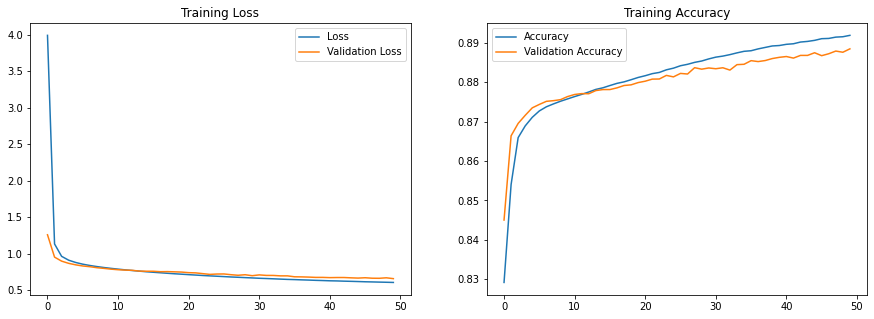

In [ ]:
# Recupero il log di addestramento
df_history = pd.read_json(log_history, lines=True)

# visualizzazione andamento addestramento
# su un grafico composto da due sub-plot
# uno per il loss, l'altro per l'accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Errore durante l'addestramento
ax1.plot(df_history['loss'], label='Loss')
ax1.plot(df_history['val_loss'], label='Validation Loss')
ax1.set_title('Training Loss')
ax1.legend()

# Accuratezza durante l'addestramento
ax2.plot(df_history['sparse_categorical_accuracy'], label='Accuracy')
ax2.plot(df_history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
ax2.set_title('Training Accuracy')
ax2.legend()

plt.show()

## Test del modello
La seguente cella permette di caricare l'ultimo checkpoint dell'addestramento
precedentemente salvato.

In [ ]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [ ]:
class Translate:
  def __init__(self, transformer_block, tokenizers):
    self.transformer = transformer_block
    self.tokenizers = tokenizers

  def predict(self, input_text, max_length):
    if input_text is None:
      input_text = input_data[np.random.choice(len(input_data))]
      print(input_text)

    inputs_bert = self.tokenizers.ita.tokenize(input_text)

    start_end = self.tokenizers.dan.tokenize([''])[0]
    start = (start_end[0][tf.newaxis]).numpy()[0]
    end = (start_end[1][tf.newaxis]).numpy()[0]

    output_array = tf.TensorArray(dtype=tf.int32, size=max_length, dynamic_size=True)
    output_array = output_array.write(0, tf.constant([start]))     

    out_words = []

    for i in tf.range(max_length):
      # decodifica e recupero probabilità di output
      output = tf.transpose(output_array.stack())

      transformer_output = transformer((inputs_bert, output), 
                                        training=False,
                                        debug=False)

      predictions = transformer_output[:, -1:, :]

      # selezione della parola più probabile
      predict = tf.argmax(predictions, -1)
      pred_values = (K.argmax(transformer_output, axis=-1)).numpy()
    
      # inserimento della parola nella sequenza di output
      output_array = output_array.write(i+1, [pred_values[0][i]])

      if pred_values[0][i] == end:
        break

    output = tf.transpose(output_array.stack())
    text = tokenizers.dan.detokenize(output)[0]  
    tokens = tokenizers.dan.lookup(output)[0]

    return text, tokens

In [ ]:
test_sequences = [test_input_data[2], test_input_data[26], test_input_data[19], 
                  test_input_data[34], test_input_data[45], test_input_data[58], 
                  test_input_data[62], test_input_data[71], test_input_data[84],
                  test_input_data[90], test_input_data[99], test_input_data[0]]

target_sequences = [test_target_data[2], test_target_data[26], test_target_data[19], 
                    test_target_data[34], test_target_data[45], test_target_data[58], 
                    test_target_data[62], test_target_data[71], test_target_data[84],
                    test_target_data[90], test_target_data[99], test_target_data[0]]


translate = Translate(transformer_block=transformer,
                      tokenizers=tokenizers)

for test_sequence, target in zip(test_sequences, target_sequences):
  text, token = translate.predict(tf.constant([test_sequence]), MAX_SEQ_LENGTH)

  print(f'{"Input":15s}: {test_sequence}')
  print(f'{"Target":15s}: {target}')
  print(f'{"Prediction":15s}: {text.numpy().decode("utf-8")}')  
  print('---------------------------------------------')


Input          : gridano , piangono e si lamentano . 
Target         : quivi le strida , il compianto , il lamento 
Prediction     : che l altro afffffettoro i piedi ,
---------------------------------------------
Input          : giu il carro rds il fondo , dove la ministress
Target         : giu ver lo fondo , la ve la ministra
Prediction     : e l altro che l suo figlio s accolse ,
---------------------------------------------
Input          : qualunque cosa si manifesti , la sua strada
Target         : ma vassi a la via sua , che che li appaia , 
Prediction     : che l aere fendea la sua vita
---------------------------------------------
Input          : il nostro amore non chiude le porte contro la volonta giusta , 
Target         :  la nostra carita non serra porte
Prediction     : che l suo figlio palido e , equama
---------------------------------------------
Input          : dopo di che , dopo un sospiro di pieta , 
Target         : ond ella , appresso d un pio sospiro , 
Pred

## Tensorboard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
log_dir

In [ ]:
%tensorboard --logdir drive/MyDrive/BERT/logs/fit/20221026-134720